In [326]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sc

from sklearn.linear_model import LinearRegression

np.random.seed(42)

In [327]:
df = pd.read_csv('data/Questionnaire to Benchmark Explainable AI Methods.csv')

In [328]:
df = df.drop('Timestamp', axis=1)
df = df.dropna()


In [329]:
df

,Is English your native language?,In which type of program are you currently enrolled?,What is your field of study related to?,In how many courses related to Artificial Intelligence did you participate?,Have you ever heard of 'Explainable AI' methods?,From the explanation I understand how the system makes a decision.,"The explanation is useful to me, for making better decisions or to perform an action.",The explanation increases my trust in the system.,The explanation provides sufficient information to explain how the system makes decisions.,I have a satisfied attitude towards the explanation of the system.,...,From the explanation I understand how the system makes a decision..2,"The explanation is useful to me, for making better decisions or to perform an action..2",The explanation increases my trust in the system..2,The explanation provides sufficient information to explain how the system makes decisions..2,I have a satisfied attitude towards the explanation of the system..2,From the explanation I understand how the system makes a decision..3,"The explanation is useful to me, for making better decisions or to perform an action..3",The explanation increases my trust in the system..3,The explanation provides sufficient information to explain how the system makes decisions..3,I have a satisfied attitude towards the explanation of the system..3
0,No,Bachelor,Other,0,No,2.0,5.0,2.0,4.0,1.0,...,2.0,3.0,1.0,1.0,1.0,1.0,4.0,2.0,4.0,5.0
1,Yes,Master,Data Science,Many,Yes,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,No,Bachelor,Psychology,1,No,6.0,5.0,4.0,5.0,5.0,...,5.0,5.0,4.0,5.0,4.0,6.0,6.0,5.0,6.0,6.0
3,No,Bachelor,Psychology,0,No,5.0,5.0,7.0,5.0,3.0,...,2.0,1.0,1.0,4.0,1.0,6.0,7.0,7.0,3.0,5.0
4,No,Master,Economics/Business,0,Yes,2.0,3.0,3.0,3.0,3.0,...,4.0,5.0,4.0,6.0,4.0,4.0,7.0,6.0,5.0,6.0
8,No,Other,Natural Sciences,0,No,4.0,5.0,5.0,3.0,5.0,...,6.0,5.0,6.0,5.0,6.0,4.0,4.0,3.0,3.0,4.0
9,No,Master,Law,0,No,6.0,6.0,4.0,6.0,5.0,...,1.0,1.0,3.0,1.0,1.0,6.0,6.0,5.0,6.0,6.0
10,No,Bachelor,Engineering,0,No,4.0,3.0,4.0,2.0,3.0,...,7.0,6.0,7.0,6.0,7.0,7.0,7.0,7.0,7.0,7.0
11,No,Master,Economics/Business,3,Yes,5.0,4.0,6.0,5.0,3.0,...,5.0,4.0,5.0,5.0,5.0,5.0,6.0,4.0,5.0,5.0
12,No,Master,Engineering,0,No,4.0,3.0,4.0,5.0,4.0,...,4.0,4.0,6.0,4.0,4.0,6.0,4.0,6.0,5.0,5.0


In [330]:
original_column_names = df.columns


In [331]:
new_columns = [f'question {i}' for i in range(1,26)]
df.columns = new_columns
df.head(15)
df.drop(1, axis=0, inplace=True)

In [332]:
ml_background = df[df['question 3'] == 'AI']
ml_background = ml_background.append(df[df['question 3'] == 'Data Science'])

In [333]:
non_ml_background = df.drop(index=ml_background.index)

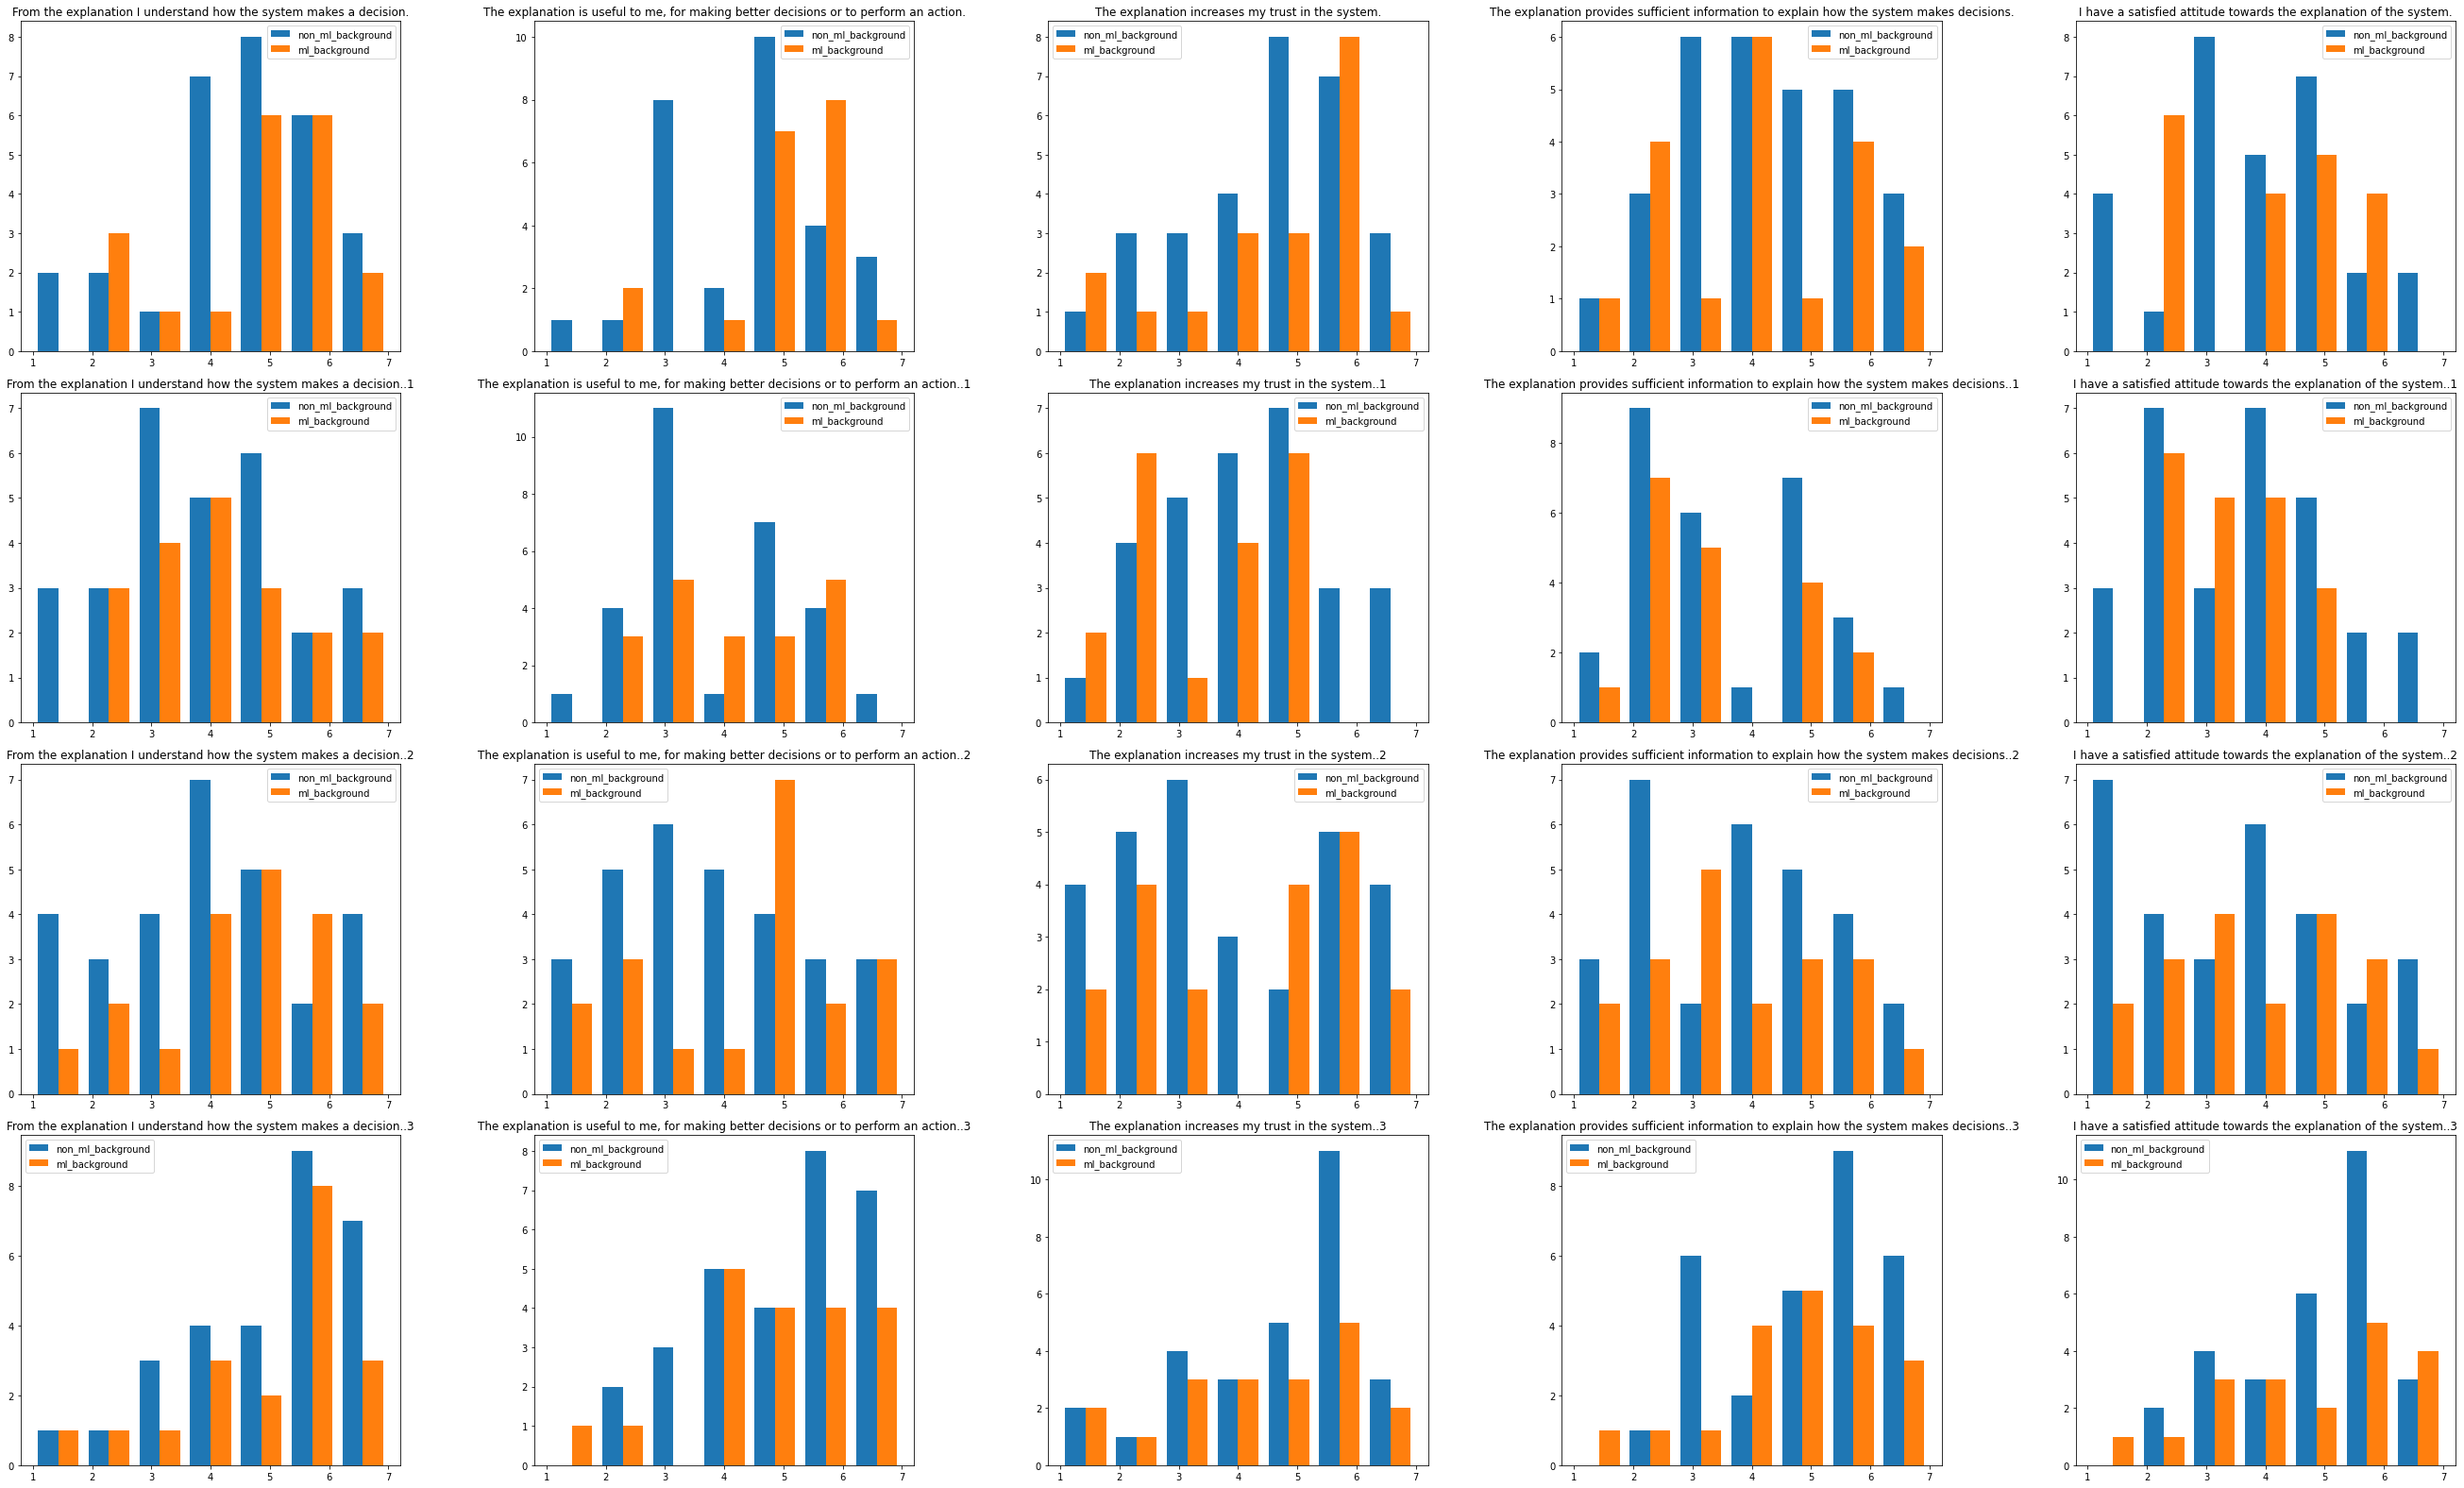

In [334]:
def get_histo_grid(safe_fig=False):
    """
    This function creates a histogram for each question.
    The data is segmented based on ML-Background
    @param safe_fig: defines if the figure is saved as .png
    @return: None
    """
    fig, axs = plt.subplots(4,5)
    fig.set_size_inches(37, 22)

    for i in range(6,26):
        data = [non_ml_background[f'question {i}'], ml_background[f'question {i}']]
        row = (i-6)//5
        col = (i-6)%5
        # axs[row,col].set_size_inches(18.5, 10.5)
        axs[row,col].hist(data, bins=7, histtype='bar',  label=['non_ml_background', 'ml_background'])
        axs[row,col].set_title(original_column_names[i-1])
        axs[row,col].legend()
    # plt.legend()
    plt.tight_layout()
    if safe_fig:
        plt.savefig('data/images/histo_grid')

get_histo_grid(safe_fig=True)


# some regressions



In [335]:

def get_regression_coeff(att_1=None, att_2=None):
    """
    This function returns all linear regression coefficients.
    if att_1 and att_2 are specified 1 regression coefficient is returned
    @param att_1: column index you want to regress from
    @param att_2: column index you want to regress to
    @return: one or all regression coefficients
    """
    if att_1 == None and att_2 == None:
        coeffs = np.zeros((20,20))
        for i in range(5,25):
            for j in range(5,25):
                X = df.iloc[:,i].values.reshape(-1,1)
                Y = df.iloc[:,j].values.reshape(-1,1)

                lin_reg = LinearRegression()
                lin_reg.fit(X,Y)
                coeffs[i-6,j-6] = lin_reg.coef_

        return coeffs
    else:
        X = df.iloc[:,att_1].values.reshape(-1,1)
        Y = df.iloc[:,att_2].values.reshape(-1,1)
        lin_reg = LinearRegression()
        lin_reg.fit(X,Y)

        return lin_reg.coef_
# get_regression_coeff()




In [336]:
def get_advanced_correlation_info():
    """
    Calculates Perarson correlation and student-t-test for every pair of features.
    the third axis is used to differenciate between test, stats-value and p-value
    @return: array with shape(20,20,4)
        shape(:,:,0) = pearsons correlation coefficient
        shape(:,:,1) = two sided p-value
        shape(:,:,2) = calculated t-test statistic
        shape(:,:,3) = two sided p-value
    """
    coeffs = np.zeros((20,20,4))


    # calc Pearson correlation coefficients
    for i in range(5,25):
        for j in range(5,25):
            x = ml_background.iloc[:,i].values
            y = non_ml_background.iloc[:,j].values
            y = np.random.choice(y, size=len(x))
            stats, p = sc.pearsonr(x,y)
            coeffs[i-6,j-6, 0] = stats
            coeffs[i-6,j-6, 1] = p


    # calc student t test coefficients
    for i in range(5,25):
            for j in range(5,25):
                x = ml_background.iloc[:,i].values
                y = non_ml_background.iloc[:,j].values
                stats, p = sc.ttest_ind(x,y, equal_var=False)
                coeffs[i-6,j-6, 2] = stats
                coeffs[i-6,j-6, 3] = p


    return coeffs

# get_advanced_correlation_info()


In [337]:
def visualize_p_values(threshold = 0.05):
    """
    This function turns visualizes the p-values. It transform all p-values above a threshold
    every pixel represents a p-value. All colored in white are above the given threshold.
    Every pixel that's above the threshold is colored white, all other pixels are black.
    @return: figure with 2 images representing p-values.
    """
    fig, ax = plt.subplots(1,2)
    coeffs = get_advanced_correlation_info()

    coeffs[:,:,1] = np.where(coeffs[:,:,1] > threshold, 0, 1)
    ax[0].imshow(coeffs[:,:,1], cmap='binary')
    ax[0].set_title('pearson p-value')


    coeffs[:,:,3] = np.where(coeffs[:,:,3] > threshold, 0, 1)
    ax[1].imshow(coeffs[:,:,3], cmap='binary')
    ax[1].set_title('t-test p-value')


    return plt.show()

# visualize_p_values()

# Research questions
the rest of the document is dedicated to the answers of our research hypothesis

## Question 1
AI novice users prefer local to global explanations, where preference is defined as an overall higher score?



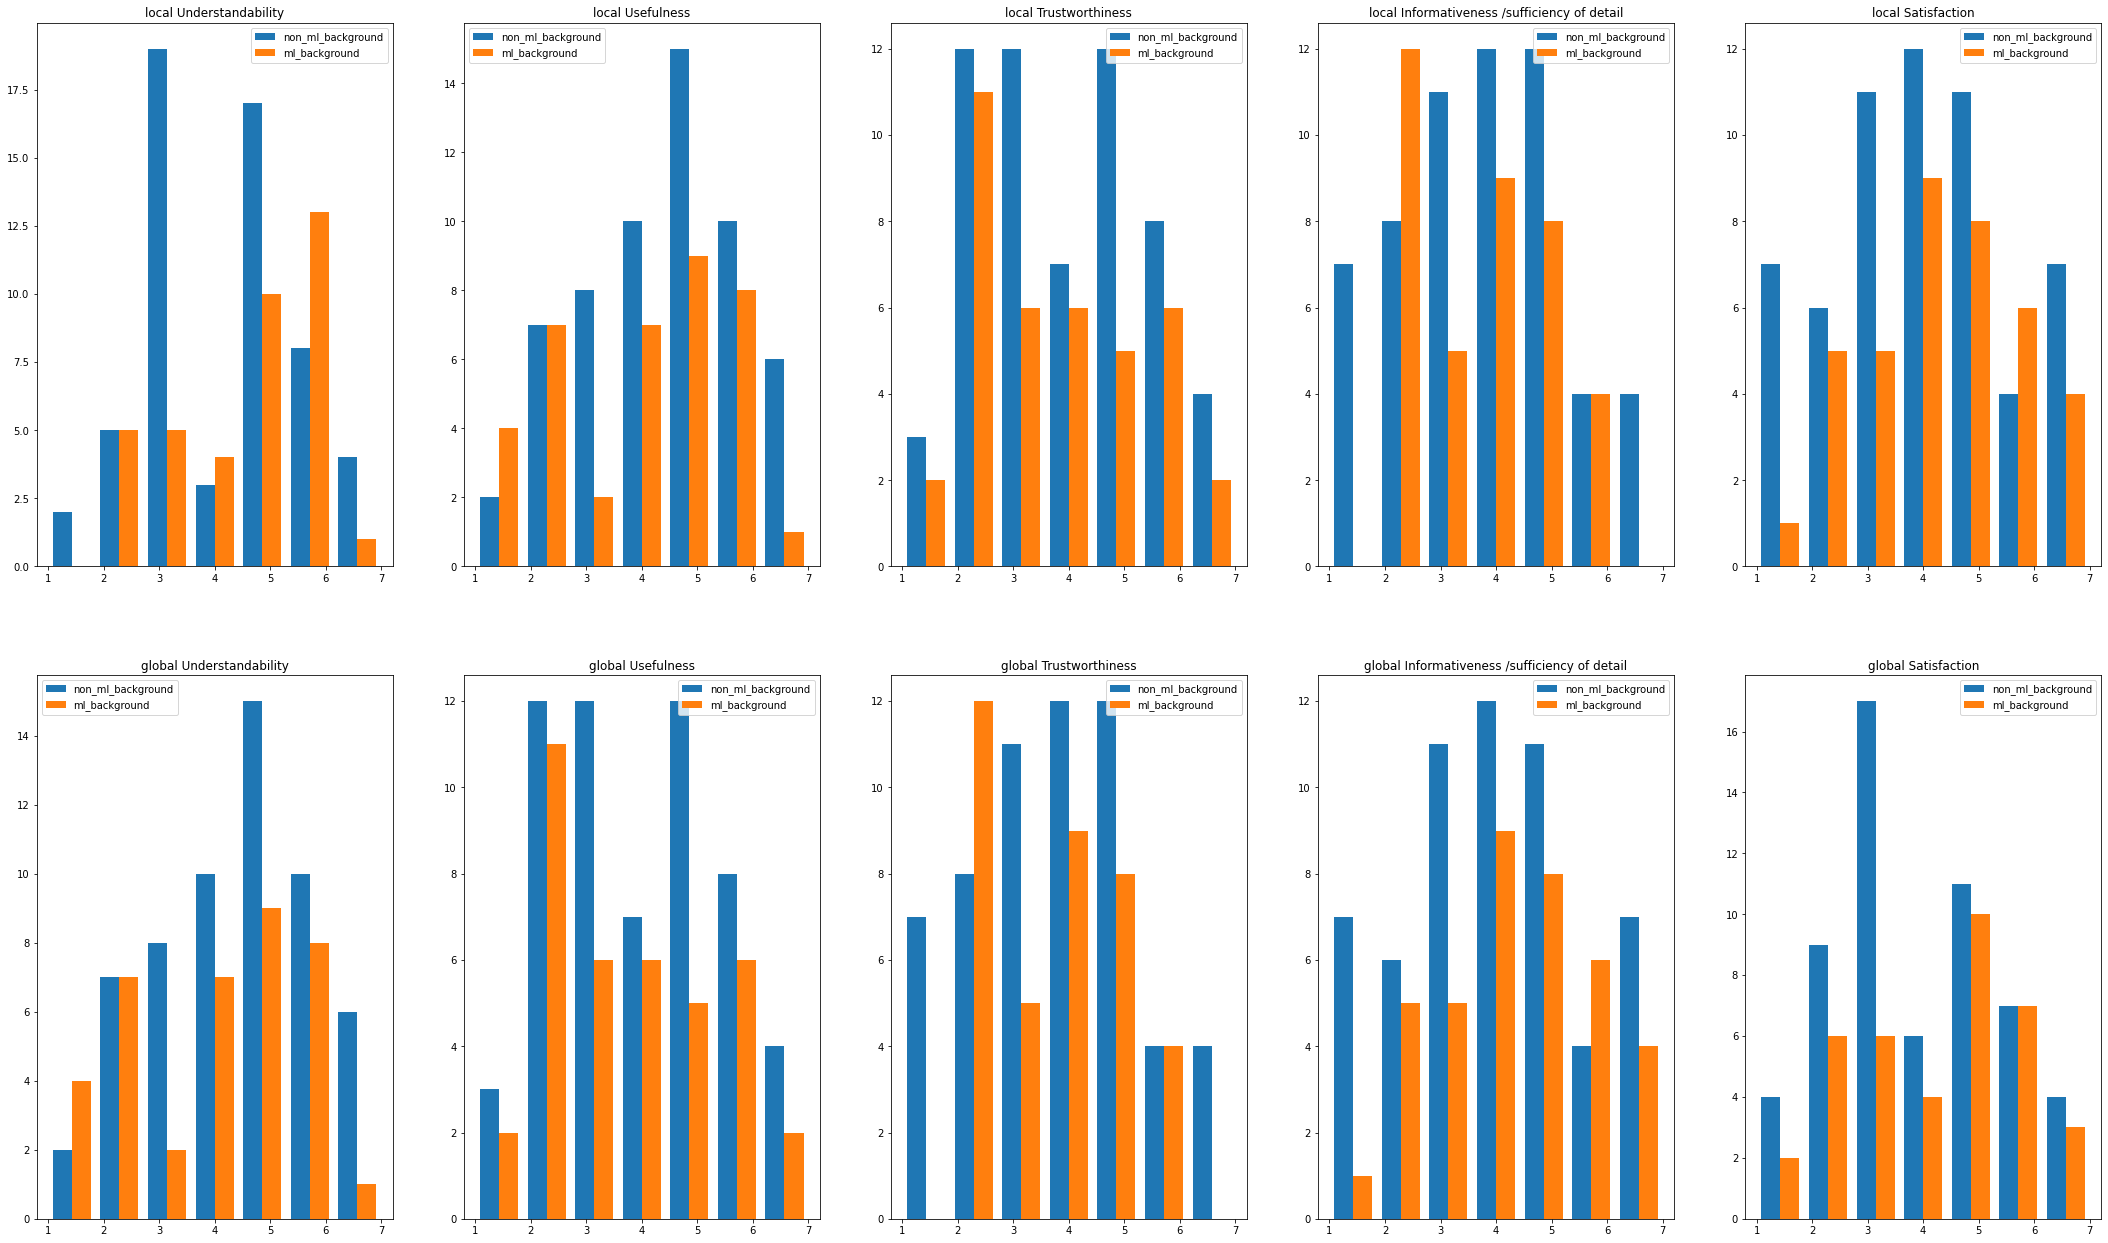

In [338]:
def get_local_vs_global_hist(drilldown=False, safe_fig=False):
    '''
    Creates histograms for local vs. global explanations.
    @param safe_fig:
    @param drilldown:
    @return:
    '''
    if drilldown:
        fig,axs = plt.subplots(2,5)
        fig.set_size_inches(37, 22)

        criteria = ['Understandability', 'Usefulness', 'Trustworthiness', 'Informativeness /sufficiency of detail', 'Satisfaction']
        for i, cat in enumerate(['local', 'global']):
            for idx, crit in enumerate(criteria):
                col1 = i+1 * idx + 6
                col2 = i+1 * idx + 11
                ml = ml_background.iloc[:,[col1,col2]].values
                non_ml = non_ml_background.iloc[:,[col1, col2]].values

                ml.reshape(1,ml.shape[0] * ml.shape[1])
                non_ml.reshape(1,non_ml.shape[0] * non_ml.shape[1])

                data = [non_ml, ml]
                axs[i,idx].set_title(cat + " " + crit)
                axs[i,idx].hist(data, bins=7, histtype='bar',  label=['non_ml_background', 'ml_background'])
                axs[i,idx].legend()
        if safe_fig:
            plt.savefig('data/images/drill_down_local_vs_global')


    else:
        fig, axs = plt.subplots(1,2)
        axs[0].set_title('local explanations')
        axs[1].set_title('global explanations')

        ml = ml_background.iloc[:,5:15].values
        ml.reshape(1,ml.shape[0] * ml.shape[1])
        non_ml = non_ml_background.iloc[:,5:15].values
        non_ml.reshape(1,non_ml.shape[0] * non_ml.shape[1])
        data = [non_ml, ml]

        axs[0].hist(data, bins=7, histtype='bar',  label=['non_ml_background', 'ml_background'])
        axs[0].legend()

        ml = ml_background.iloc[:,15:25].values
        ml.reshape(1,ml.shape[0] * ml.shape[1])
        non_ml = non_ml_background.iloc[:,15:25].values
        non_ml.reshape(1,non_ml.shape[0] * non_ml.shape[1])
        data = [non_ml, ml]

        axs[1].hist(data, bins=7, histtype='bar',  label=['non_ml_background', 'ml_background'])
        axs[1].legend()

        plt.tight_layout()
        if safe_fig:
            plt.savefig('data/images/local_vs_global')
        plt.show()

get_local_vs_global_hist(drilldown=True, safe_fig=True)



In [339]:
def calculate_statistics(threshold=0.05, dataset=non_ml_background):
    '''
    This function calculates a statistic to assess if local or global explanations are better.
    @param threshold: the threshold applied to the t-test to see if something is counted as significant
    @param dataset: the dataset to use.
    @return: creates a pandas table with survey criteria as rows and evaluation criteria as columns
    '''
    vals = np.zeros((5,4))
    for idx in range(5):


        loc = dataset.iloc[:,idx+5].append(dataset.iloc[:,idx+10])
        glo = dataset.iloc[:,idx+15].append(dataset.iloc[:,idx+20])
        mean_l = np.mean(loc)
        mean_g = np.mean(glo)
        glo_greq_loc = mean_l >= mean_g
        stat, p = sc.ttest_ind(loc, glo)
        significant = p > threshold

        vals[idx,0] = mean_l
        vals[idx,1] = mean_g
        vals[idx,2] = glo_greq_loc
        vals[idx,3] = significant
    differences = pd.DataFrame(index=['Understandability', 'Usefulness', 'Trustworthiness', 'Informativeness /sufficiency of detail', 'Satisfaction'],
                               columns=['mean_local', 'mean_global', 'local >= global', 'significant'], data=vals
                               )
    return differences

calculate_statistics()

,mean_local,mean_global,local >= global,significant
Understandability,4.258621,4.586207,0.0,1.0
Usefulness,4.172414,4.482759,0.0,1.0
Trustworthiness,4.431034,4.344828,1.0,1.0
Informativeness /sufficiency of detail,3.913793,4.465517,0.0,1.0
Satisfaction,3.724138,4.241379,0.0,1.0


as we can see from the table above, global explanations seem to perform better than local ones.
This goes for all categories except of Trustworthiness.
The difference is significant according to a students t-test with threshold = 0.05

## question 2
Is there a preference towards local or global explanations for AI experts, where preference is defined as an overall higher score?

In [340]:

calculate_statistics(dataset=ml_background)

,mean_local,mean_global,local >= global,significant
Understandability,4.526316,4.842105,0.0,1.0
Usefulness,4.631579,4.684211,0.0,1.0
Trustworthiness,4.000000,4.315789,0.0,1.0
Informativeness /sufficiency of detail,3.710526,4.289474,0.0,1.0
Satisfaction,3.657895,4.342105,0.0,1.0


as we can see in the table, for AI experts the picture is quite similar to AI novice users.
The only notable difference is, that AI users acchive better scores in all categories without exception.
Again these differences are significant based on the Students t-test with threshold = 0.05

## question 3
Explanations (in general) increase users’ trust in a system. (trustworthiness)

To answer this question it has to be assumed, that all participants interpreted the likert scale correctly.
Thus, 4 is a neutral answer and any answer lower/higher than 4 is a decrease/increase.
Hence, it has to be checked if the median, and the mean is above or below 4.
Trustworthiness was assessed with the third question for each explanation

In [341]:
def assess_item(item_nr=0, dataset=df):
    '''
    This function calculates the mean and the median of a given item
    This uses the fact that we have 5 similar items per question
    @param item_nr: item number is 0 based, implying that the first item per question is item_nr=0
    @param dataset: the dataset for which a item should be
    @return: creates a table with different XAI-methods as rows and mean and median as colunns
    '''
    rows = ['lime', 'shap_local', 'shap_global', 'pdp']
    values = np.zeros((4,2))
    items = np.arange(start=item_nr+5, stop=25,step=5)
    for idx, pos in enumerate(items):
        data = dataset.iloc[:,pos]
        mean = np.mean(data)
        median = np.median(data)
        values[idx, 0] = mean
        values[idx, 1] = median
    results = pd.DataFrame(
        columns=['mean', 'median'],
        index=rows,
        data=values
    )
    return results

assess_item(2)

,mean,median
lime,4.666667,5.0
shap_local,3.854167,4.0
shap_global,4.000000,4.0
pdp,4.666667,5.0


As we can see in the table above explanations provided by lime and pdp seems to increase the trust in the AI system.
However, shap_global performs acceptably, meaning that it does not influence the mean trustworthiness of our population.
Shap_local on the other decreases the mean trust below 4.

## question 4
Explanations help AI novices to (better) understand a ML system.

To answer this question the same assumptions as for question 3 apply.
Understandability was assessed with the first question for each explanation.


In [342]:
assess_item(item_nr=1, dataset=non_ml_background)#


,mean,median
lime,4.482759,5.0
shap_local,3.862069,3.0
shap_global,3.793103,4.0
pdp,5.172414,6.0


This table shows that the Understandability of only half the explanations is greater than 4.
As with trustworthiness shap provides scores lower or equal to 4.
However pdp seems to provide overwhelmingly positive results. Mean and Median arethe highest of all XAI methods compared.
Furthermore, it's noticable, that the median of pdp is at 6 and therefore only 1 point below the maximum possible.



## Question 5

Hypothesis: Between LIME and SHAP local explanations, AI novices prefer LIME. 
#(preference = overall higher scores for all evaluation criteria)

First we need to define AI novices and AI expert instances. Then the visualization is based on a single chart per criteria. At the same time, each chart contains two histograms, one for each XAI method. (Double click on the visualization to zoom it).

Morover, a table is added containing the mean of the votes and standard deviation per criteria and per method. 

Criteria             Mean LIME    Mean SHAP    Std LIME    Std SHAP
-----------------  -----------  -----------  ----------  ----------
Understandability      4.66667      3.875       1.74801     1.83286
Usefulness             4.625        3.91667     1.54953     1.55233
Trustworthiness        4.58333      4.20833     1.68119     1.68274
Informativeness        4.33333      3.66667     1.69967     1.72401
Satisfaction           3.91667      3.66667     1.77756     1.77169



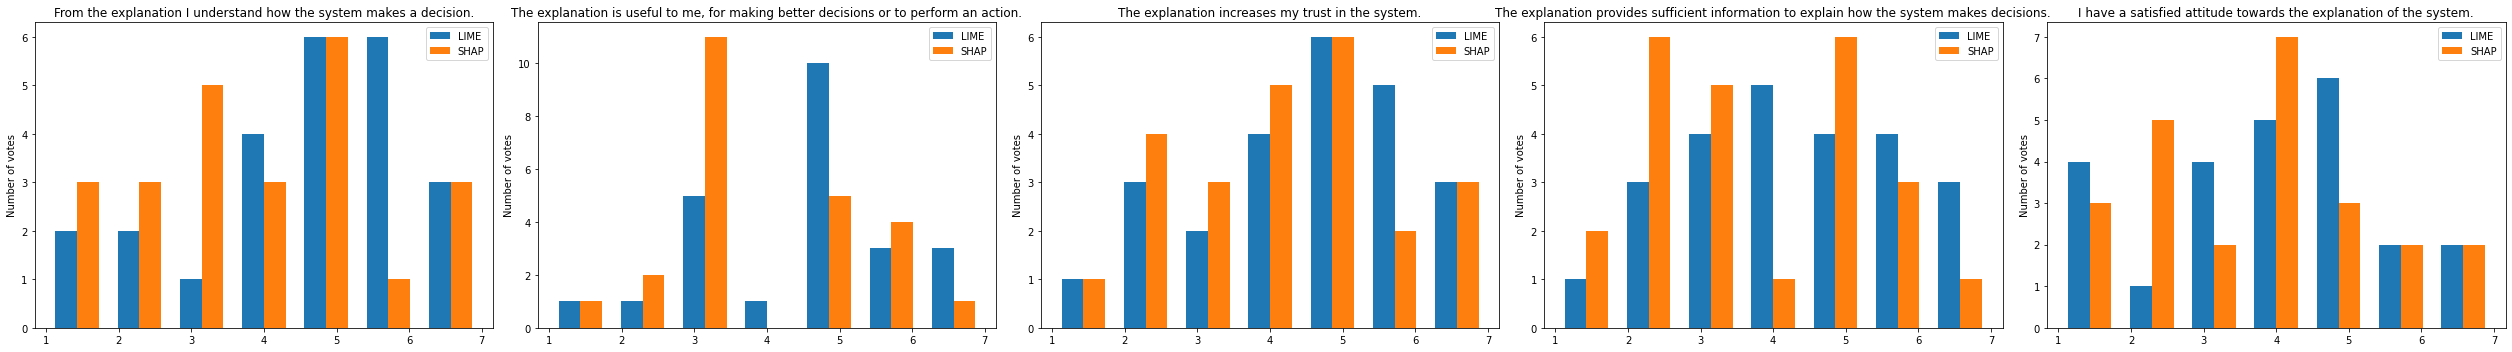

In [19]:
#Defining AI novices and AI expert instances

ai_novice = df[df['question 4'] == '0']
ai_novice = ai_novice.append(df[df['question 4'] == '1'])

ai_expert = df.drop(index=ai_novice.index)

#Question 5 analysis

from scipy.stats import norm
from tabulate import tabulate

def get_histo_grid(safe_fig=False):
    
    fig, axs = plt.subplots(1,5)
    fig.set_size_inches(35, 5)
    # fig.subplots_adjust(hspace=1.0, wspace=1.0)
    table = [] 
    mu1=[]
    mu2=[]
    std1=[]
    std2=[]
        
    
    for i in range(6,11):
        data = [ai_novice[f'question {i}'], ai_novice[f'question {i+5}']]
        row = 1
        col = (i-6)%5
        
        axs[col].hist(data, bins=7, histtype='bar',  label=['LIME','SHAP'],rwidth=0.7)
        axs[col].set_title(original_column_names[i-1])
        axs[col].legend()
        axs[col].set_ylabel('Number of votes')
        
        data1 = ai_novice[f'question {i}']
        data2 = ai_novice[f'question {i+5}']
        
        mu, std = norm.fit(data1)
        mu3, std3 = norm.fit(data2)
        
        mu1.append(mu)
        mu2.append(mu3)
        std1.append(std)
        std2.append(std3)
        
        criteria = ['Understandability','Usefulness','Trustworthiness','Informativeness','Satisfaction']
        column = criteria[i-6], mu1[i-6],mu2[i-6],std1[i-6],std2[i-6]
        table.append(column)
    
    
    
    print(tabulate((table), headers=['Criteria', 'Mean LIME', 'Mean SHAP', 'Std LIME' ,'Std SHAP']))
    print('')
    plt.tight_layout()
    if safe_fig:
        plt.savefig('histo_grid')

get_histo_grid(safe_fig=True)


## Question 6

Hypothesis: Explanations provide additional information about the system.(informativeness).
This analisys just involve comparing the histograms of the four XAI methods for the survey question 'The explanation provides sufficient information to explain how the system makes decisions'.

The histograms plot are for the completion of the notebook (double click on it to zoom it). In the report will be the Tableau ones.

Method          Mean      Std
-----------  -------  -------
LIME         4.19565  1.73981
SHAP-local   3.36957  1.65974
SHAP-global  3.71739  1.78962
PDP          4.97826  1.56718



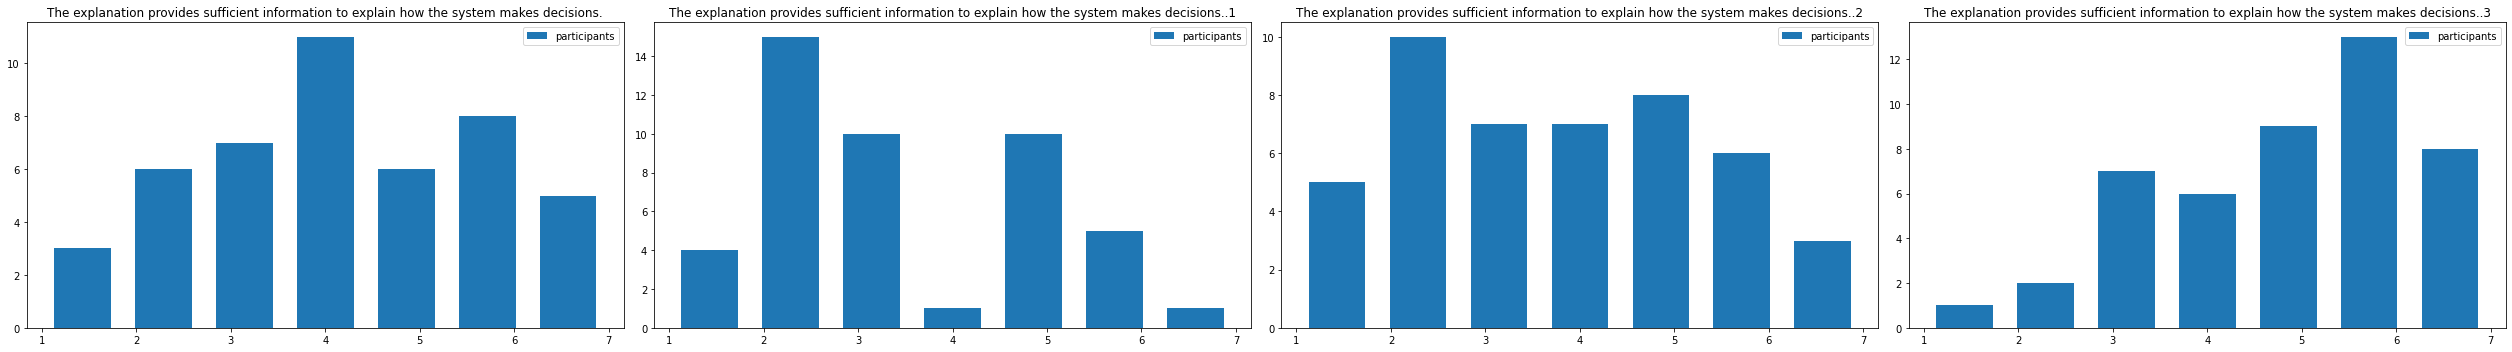

In [149]:
#Histograms for question 6:H: Explanations provide additional information about the system.(informativeness)

def get_histo_grid(safe_fig=False):

    fig, axs = plt.subplots(1,4)
    fig.set_size_inches(35,5 )
    # fig.subplots_adjust(hspace=1.0, wspace=1.0)
    feature_list = ["9", "14", "19", "24"]
    feature_list = list(map(int, feature_list))
    counter=0
    table = [] 
    mu1=[]
    std1=[]
    
    for i in feature_list:
        data = [df[f'question {i}']]
        col = (i-6)//5
        row = 1
        # axs[row,col].set_size_inches(18.5, 10.5)
        axs[col].hist(data, bins=7, histtype='bar',  label=['participants'],rwidth=0.7)
        axs[col].set_title(original_column_names[i-1])
        axs[col].legend()
        
        mu, std = norm.fit(data)
        mu1.append(mu)
        std1.append(std)
        
        methods = ['LIME','SHAP-local','SHAP-global','PDP']
        column = methods[counter], mu1[counter], std1[counter]
        table.append(column)
        counter = counter+1
    
    print(tabulate((table), headers=['Method', 'Mean', 'Std']))
    print('')
    plt.tight_layout()
    if safe_fig:
        plt.savefig('histo_grid')

get_histo_grid(safe_fig=True)


## Question 7

Question: Are explanations useful to AI novices and AI experts? (usefulness)
This analisys just involve comparing the histograms of the four XAI methods for the survey question 'The explanation is useful to me, for making better decisions or to perform an action'.

The histograms plot are for the completion of the notebook (double click on it to zoom it). In the report will be the Tableau ones.

Method          Mean      Std
-----------  -------  -------
LIME         4.63043  1.57919
SHAP-local   3.82609  1.56461
SHAP-global  4        1.91107
PDP          5.08696  1.58562



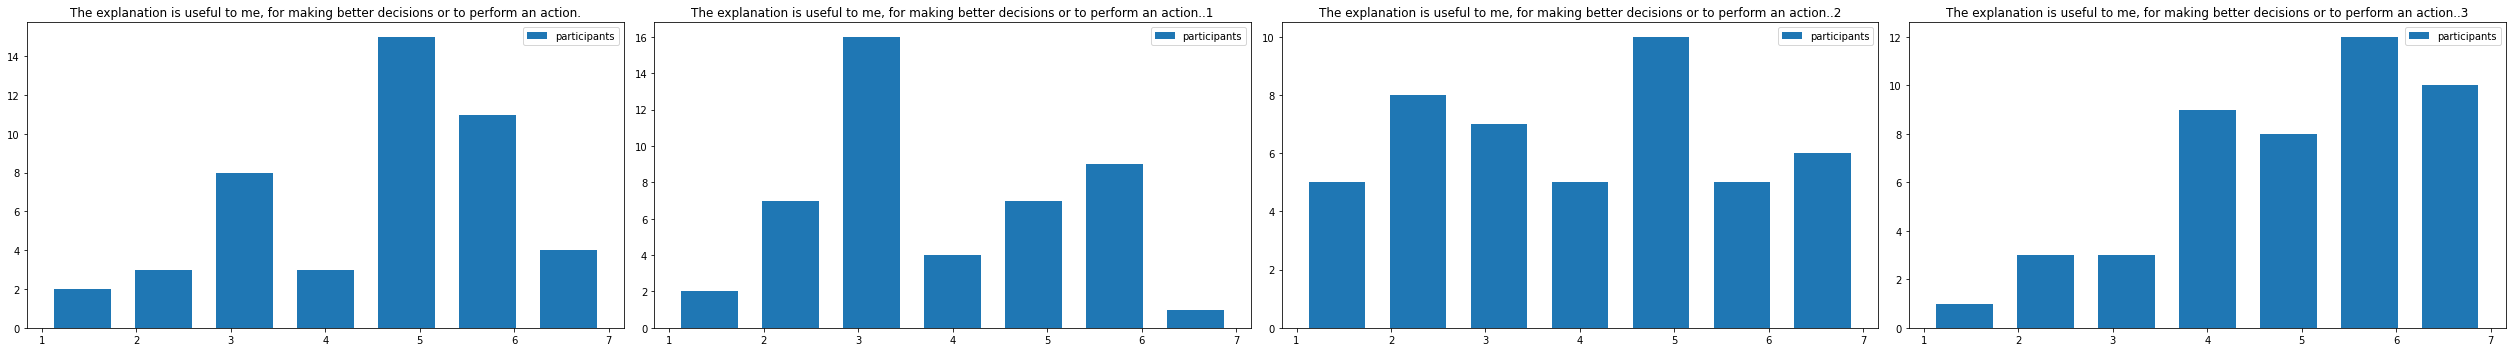

In [151]:
#Histograms for question 7:Q: Are explanations useful to AI novices and AI experts? (usefulness)

def get_histo_grid(safe_fig=False):
   
    fig, axs = plt.subplots(1,4)
    fig.set_size_inches(35,5 )
    # fig.subplots_adjust(hspace=1.0, wspace=1.0)
    feature_list = ["7", "12", "17", "22"]
    feature_list = list(map(int, feature_list))
    counter=0
    table = [] 
    mu1=[]
    std1=[]
    
    for i in feature_list:
        data = [df[f'question {i}']]
        col = (i-6)//5
        row = 1
        
        axs[col].hist(data, bins=7, histtype='bar',  label=['participants'],rwidth=0.7)
        axs[col].set_title(original_column_names[i-1])
        axs[col].legend()
        
        mu, std = norm.fit(data)
        mu1.append(mu)
        std1.append(std)
        
        methods = ['LIME','SHAP-local','SHAP-global','PDP']
        column = methods[counter], mu1[counter], std1[counter]
        table.append(column)
        counter = counter+1
    
    print(tabulate((table), headers=['Method', 'Mean', 'Std']))
    print('')
    plt.tight_layout()
    if safe_fig:
        plt.savefig('histo_grid')

get_histo_grid(safe_fig=True)


## Question 8 

Question: Are users more satisfied with a system if they are given explanations of the system? (satisfaction)

This analisys just involve comparing the histograms of the four XAI methods for the survey question 'I have a satisfied attitude towards the explanation of the system.'.

The histograms plot are for the completion of the notebook (double click on it to zoom it). In the report will be the Tableau ones.

Method          Mean      Std
-----------  -------  -------
LIME         3.84783  1.66769
SHAP-local   3.43478  1.56944
SHAP-global  3.6087   1.93905
PDP          4.91304  1.58562



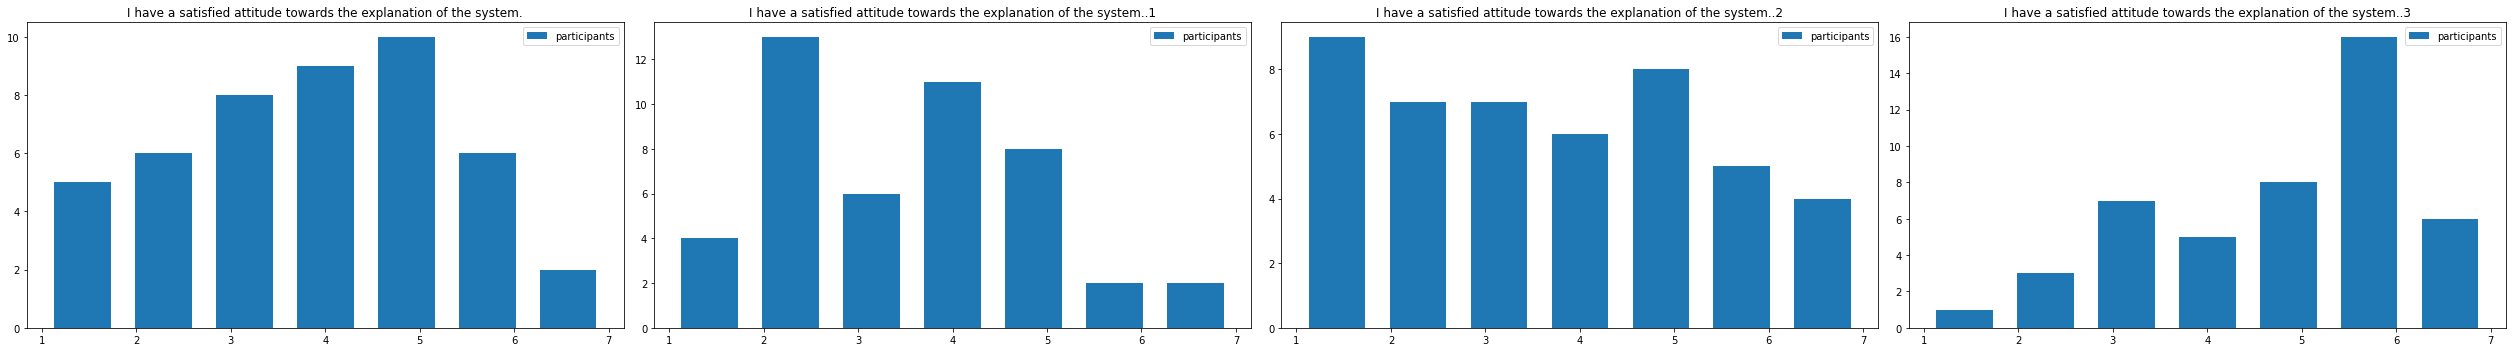

In [153]:
#Histograms for question 8:Q: Are users more satisfied with a system if they are given explanations of the system? (satisfaction)

def get_histo_grid(safe_fig=False):
   
    fig, axs = plt.subplots(1,4)
    fig.set_size_inches(35,5 )
    # fig.subplots_adjust(hspace=1.0, wspace=1.0)
    feature_list = ["10", "15", "20", "25"]
    feature_list = list(map(int, feature_list))
    counter=0
    table = [] 
    mu1=[]
    std1=[]
    
    for i in feature_list:
        data = [df[f'question {i}']]
        col = (i-6)//5
        row = 1
        
        axs[col].hist(data, bins=7, histtype='bar',  label=['participants'],rwidth=0.7)
        axs[col].set_title(original_column_names[i-1])
        axs[col].legend()
        
        mu, std = norm.fit(data)
        mu1.append(mu)
        std1.append(std)
        
        methods = ['LIME','SHAP-local','SHAP-global','PDP']
        column = methods[counter], mu1[counter], std1[counter]
        table.append(column)
        counter = counter+1
    
    print(tabulate((table), headers=['Method', 'Mean', 'Std']))
    print('')
    plt.tight_layout()
    if safe_fig:
        plt.savefig('histo_grid')

get_histo_grid(safe_fig=True)


Further explanation would be given based on our decisions tomorrow